## Summary notes

*Add slug*

## Dependencies

In [1]:
import os
import requests
import numpy as np
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.typing import ArrayLike

## Functions

In [2]:
def cache_file(url: str, fname: str, dir_: str = './__cache') -> str:
    """Cache the file at given url in the given dir_ with the given
    fname and return the local path.

    Preconditions:
    - dir_ exists
    """
    local_path = f'{dir_}/{fname}'
    if fname not in os.listdir(dir_):
        r = requests.get(url, allow_redirects=True)
        open(local_path, 'wb').write(r.content)
    return local_path

In [3]:
def get_odds_arr(df: pd.DataFrame) -> ArrayLike:
    """Return the dose-specific odds.

    Pre-conditions:
    - (dose, n_cases, n_controls) is a permutation of columns(df)
    """
    return df['n_cases'].div(df['n_controls']).to_numpy()

In [4]:
def get_dose_odds_ratios_arr(df: pd.DataFrame, ref_dose: str) -> ArrayLike:
    """Return the dose-specific odds ratios.

    Pre-conditions:
    - (dose, n_cases, n_controls) is a permutation of columns(df)
    - ref_dose in df(dose)
    """
    odds_arr = df.pipe(get_odds_arr)
    idx_ref_odds = np.where(df['dose'].to_numpy() == ref_dose)[0][0]
    ref_odds = odds_arr[idx_ref_odds]
    return odds_arr / ref_odds

## Main

### Set theme

In [5]:
sns.set_theme()

### Initialise the labels

In [6]:
doses = ['minimal', 'moderate', 'high', 'severe', 'very severe', 'extreme']
ref_dose = 'minimal'

### Cache the data

In [7]:
local_path = cache_file(
        url=('https://raw.githubusercontent.com/ljk233/laughingrook-datasets'
             + '/main/m249/medical/ptsd.csv'),
        fname='ptsd.csv'
)

### Load the data

Use the cached file to initialise a `DataFrame`.

In [8]:
data = pd.read_csv(local_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dose        6 non-null      object
 1   n_cases     6 non-null      int64 
 2   n_controls  6 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 272.0+ bytes


Output a view of *data*.

In [9]:
data

,dose,n_cases,n_controls
0,extreme,174,595
1,very severe,260,1155
2,severe,362,2688
3,high,97,1286
4,moderate,180,2783
5,minimal,95,2749


### Prepare the data

Initialise a new `DataFrame` using *data*, with the column *dose* as an ordered `Categorical` index to ensure that the data will be sorted as expected.


In [10]:
cat_data = pd.DataFrame().assign(
    dose=pd.Categorical(data['dose'], doses, ordered=True),
    n_cases=data['n_cases'].to_numpy(),
    n_controls=data['n_controls'].to_numpy()
).sort_values(
    by=['dose'],
    ascending=False
)
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dose        6 non-null      category
 1   n_cases     6 non-null      int64   
 2   n_controls  6 non-null      int64   
dtypes: category(1), int64(2)
memory usage: 370.0 bytes


Output data with marginal subtotals.

In [11]:
cat_data.melt(
    id_vars='dose',
    var_name='n_casecons'
).pivot_table(
    index='dose',
    columns='n_casecons',
    values='value',
    aggfunc='sum',
    margins=True,
    margins_name='subtotal'
)

n_casecons,n_cases,n_controls,subtotal
dose,,,
minimal,95,2749,2844
moderate,180,2783,2963
high,97,1286,1383
severe,362,2688,3050
very severe,260,1155,1415
extreme,174,595,769
subtotal,1168,11256,12424


### Dose-specific odds and odds ratios

Get data with the dose-specific odds, log(odds), and odds ratios.

In [12]:
cat_data.assign(
    odds=cat_data.pipe(get_odds_arr),
    log_odds=np.log(cat_data.pipe(get_odds_arr)),
    odds_ratio=cat_data.pipe(get_dose_odds_ratios_arr, ref_dose)
)

,dose,n_cases,n_controls,odds,log_odds,odds_ratio
0,extreme,174,595,0.292437,-1.229506,8.462203
1,very severe,260,1155,0.225108,-1.491174,6.513921
2,severe,362,2688,0.134673,-2.004908,3.897000
3,high,97,1286,0.075428,-2.584581,2.182639
4,moderate,180,2783,0.064678,-2.738328,1.871589
5,minimal,95,2749,0.034558,-3.365116,1.000000


### Test for no linear trend

Get the dose-specific log(odds).

In [13]:
log_odds = np.log(cat_data.pipe(get_odds_arr))

Plot the dose-specific log(odds).

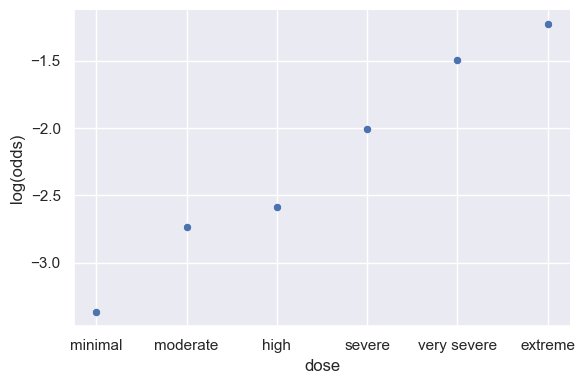

In [14]:
sns.relplot(
        x=cat_data['dose'],
        y=log_odds,
        kind='scatter',
        height=4,
        aspect=1.5
)
plt.ylabel('log(odds)')
plt.show()

Return the result of a test of no linear trend.

In [15]:
_r = st.linregress(
    x=log_odds,
    y=np.arange(log_odds.shape[0])
)
pd.Series(
    data=_r.pvalue,
    index=['pvalue'],
    name='test for no linear trend'
).round(
    6
)

pvalue    0.000111
Name: test for no linear trend, dtype: float64

## References